* This notebook was made to reproduce one set of the drifter particle tracks and summarize the statistics.

In [1]:
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import numpy as np
from salishsea_tools import tidetools
from salishsea_tools import (nc_tools,viz_tools,bathy_tools)
import matplotlib.cm as cm
import scipy.io
import os
import datetime as dt
import drifter

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2.5})

%matplotlib inline

In [2]:
grid1 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bath = {}; lons = {};lats = {}
for grid,na in zip([grid1,grid2],['bathy2','bathy6']):
    bathy, X, Y = tidetools.get_bathy_data(grid)
    lats[na] = grid.variables['nav_lat']
    lons[na] = grid.variables['nav_lon']
    bath[na] = grid.variables['Bathymetry']

In [3]:
## load drifter
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

In [4]:
def plot_total(tracks, startdate, lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration,i=0, fancy=False):
    """ This function was made to plot drifter track, particle
    of nowcast, longriver, reduced viscosity&diffusivity, and ssh 
    together
    """
    fig,axs = plt.subplots(2,2,figsize=(14,14))
    ax = axs[0,0]
    ind =drifter.find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    #print ('Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours')
    ax.plot(traj['lon'],traj['lat'],'og',label = 'data')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    ax.legend(loc = 2)
    
    #[j,i]=tidetools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,bathy,\
                #lon_tol=0.0052,lat_tol=0.00210, allow_land=False)
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    if fancy:
        cmap = plt.get_cmap('winter_r')
        cmap.set_bad('burlywood')
        ax.pcolormesh(X, Y, bathy, cmap=cmap)
        ax.set_title('Observed Drift Track')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.text(-123.15,49.13, "Fraser River", fontsize=12)
    else:
        viz_tools.plot_coastline(ax, grid1, coords='map')
        viz_tools.plot_coastline(ax, grid1, coords='map',isobath=20)
        #print ('NEMO coords:', j,i)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.3])
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    colors = ['b','m','cyan','r']
    ## particle
    ax = axs[0,1]
    key = 'Baseline'
    ax.scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[0],label=key,s = 26)
    ax.scatter(lon[key][0,part],lat[key][0,part],color='grey',marker='s')
    key = 'LongRiverOnly'
    ax.scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[1],label=key,s = 26)
    ax.plot(lon[key][0,part],lat[key][0,part],'sr')
    viz_tools.plot_coastline(ax, grid2, coords='map',color = 'm')
    viz_tools.plot_coastline(ax, grid2, coords='map',isobath=20,color = 'm')
    viz_tools.plot_coastline(ax, grid1, coords='map',color = 'b')

    ##ssh
    ax = axs[1,0]
    
    t_t = nc_tools.timestamp(tracersT, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)  
    ax.plot(tt,ssh[:,466,329],'-k',linewidth = 3.0)
    ax.set_ylabel('Modeled sea surface height at Vancouver [m]')
    ax.set_xlabel('Oct8-10,2014')
    
    t=hour
    ax.plot([tt[t],tt[t]],[-2.0,1.5],'b-',label='start',linewidth = 3)
    t2=hour+duration
    ax.plot([tt[t2],tt[t2]],[-2.0,1.5],'r-',label='end',linewidth = 3)
    ax.legend(loc = 'best')
    
    ax = axs[1,1]
    
    key = 'LongRiver+LowerViscosity'
    ax.scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[2],label=key,s= 26)
    ax.plot(lon[key][0,part],lat[key][0,part],'sr')
    key = 'LongRiver+LowerBoth'
    ax.scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[3],label=key,s= 26)
    ax.plot(lon[key][0,part],lat[key][0,part],'sr')
    viz_tools.plot_coastline(ax, grid2, coords='map')
    viz_tools.plot_coastline(ax, grid2, coords='map',isobath=20)
    
    for ax,grid in zip([axs[0,1],axs[1,1]],[grid1,grid2]):
        ax.set_xlim([-123.6,-123])
        ax.set_ylim([48.8,49.3])
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')  
        ax.legend(loc = 2)
    return fig

In [5]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']

In [6]:
drop = 'drop1/12'
runs=['oct8_10RFdailySmoo','oct8_10reduceviscosity','oct8_10','oct8_101e061e05']
strings = ['LongRiverOnly','LongRiver+LowerViscosity','Baseline','LongRiver+LowerBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon112 = {}; lat112={}
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon112[string] = f.variables['traj_lon']
    lat112[string] = f.variables['traj_lat']

/home/jieliu/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


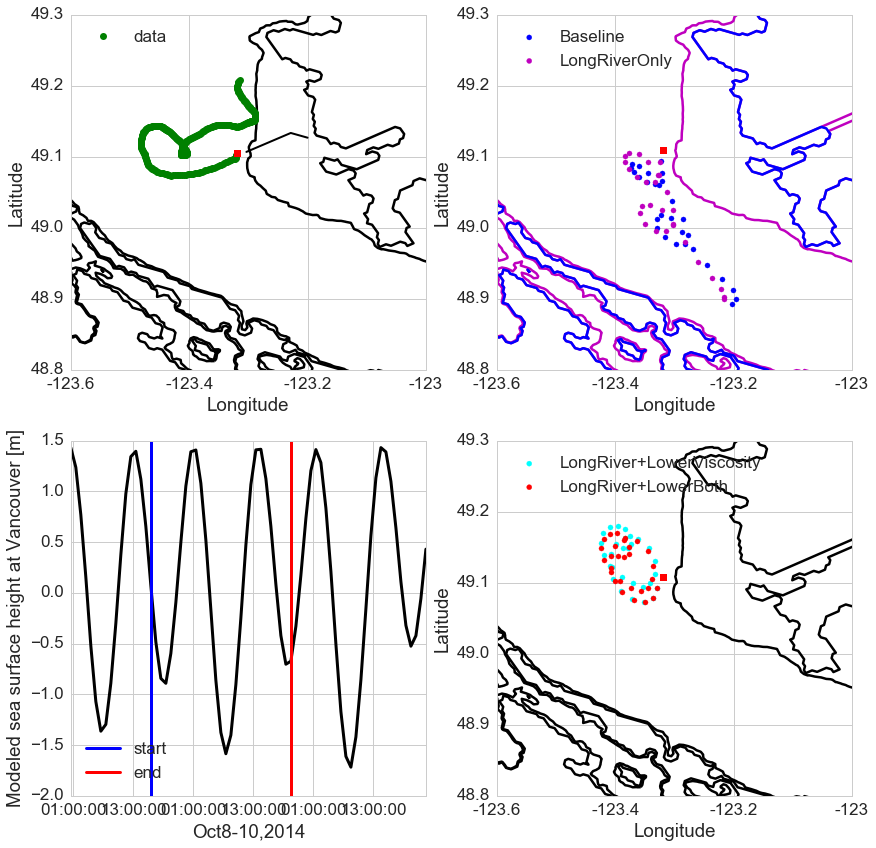

In [7]:
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)

fig=plot_total(tracks,dt.datetime(2014,10,8),lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29,i=-1)

# Statistics

In [8]:
def dist_buoy_particle(lon_dri, lat_dri, lon_par,lat_par,part):
    dist = {};
    for string in strings:
        dist[string] = np.sqrt((lon_par[string][1][part] - lon_dri)**2 +\
        (lat_par[string][1][part] - lat_dri)**2) *111*np.cos(lat_par[string][1][part]*np.pi/180)
    return dist

In [9]:
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist1 = dist_buoy_particle(lon_dri,lat_dri,lon112,lat112,0)

In [10]:
buoy = 3
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist2 = dist_buoy_particle(lon_dri,lat_dri,lon112,lat112,1)

In [11]:
drop = 'drop1/3'
lon13 = {}; lat13={}
for run,string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon13[string] = f.variables['traj_lon']
    lat13[string] = f.variables['traj_lat']

In [12]:
buoy = 9
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist3 = dist_buoy_particle(lon_dri,lat_dri,lon13,lat13,0)

In [13]:
drop = 'drop2/12'
lon212 = {}; lat212={}
for run,string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon212[string] = f.variables['traj_lon']
    lat212[string] = f.variables['traj_lat']

In [14]:
buoy = 1
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist4 = dist_buoy_particle(lon_dri,lat_dri,lon212,lat212,0)

In [15]:
buoy = 4
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist5 = dist_buoy_particle(lon_dri,lat_dri,lon212,lat212,1)

In [16]:
drop = 'drop2/3'
lon23 = {}; lat23={}
for run,string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon23[string] = f.variables['traj_lon']
    lat23[string] = f.variables['traj_lat']

In [17]:
buoy = 7
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist6 = dist_buoy_particle(lon_dri,lat_dri,lon23,lat23,0)

In [18]:
drop = 'drop3/1'
lon31 = {}; lat31={}
for run,string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon31[string] = f.variables['traj_lon']
    lat31[string] = f.variables['traj_lat']

In [19]:
buoy = 0
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist7 = dist_buoy_particle(lon_dri,lat_dri,lon31,lat31,0)

In [20]:
drop = 'drop3/23'
lon323 = {}; lat323={}
for run,string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon323[string] = f.variables['traj_lon']
    lat323[string] = f.variables['traj_lat']

In [21]:
buoy = 5
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist8 = dist_buoy_particle(lon_dri,lat_dri,lon323,lat323,0)

In [22]:
buoy = 6
name, tracks=drifter.organize_info(buoy,ubc)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist9 = dist_buoy_particle(lon_dri,lat_dri,lon323,lat323,1)

In [23]:
## dists
dists = [dist1, dist2, dist3,dist4, dist5,\
            dist6, dist7,dist8,dist9]
run1s = []; run2s=[];
run3s = []; run4s = [];
for dist in dists:
    run1s.append(dist['Baseline'])
    run2s.append(dist['LongRiverOnly'])
    run3s.append(dist['LongRiver+LowerViscosity'])
    run4s.append(dist['LongRiver+LowerBoth'])

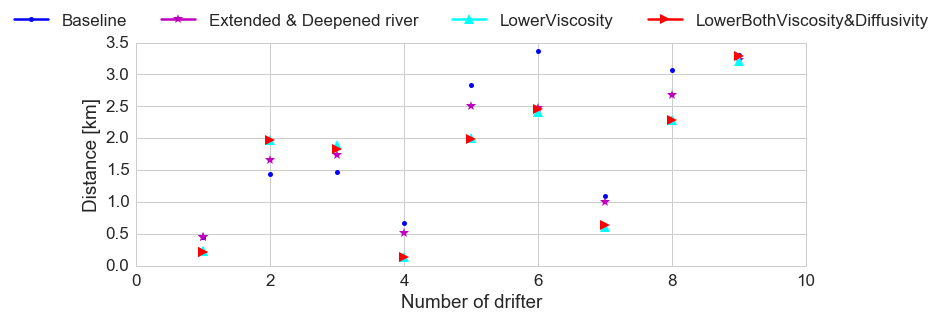

In [24]:
fig,ax1= plt.subplots(1,1,figsize=(12,4))
size = 10
x = np.arange(9)
x+=1
for i in x:
    ax1.plot(i,run1s[i-1],color = 'b',marker = '.',markersize = size)
    ax1.plot(i,run2s[i-1],color = 'm',marker = '*',markersize = size)
    ax1.plot(i,run3s[i-1],color = 'cyan',marker = '^',markersize = size)
    ax1.plot(i,run4s[i-1],color = 'r',marker = '>',markersize = size)
run1, = ax1.plot(1, run1s[0],color = 'b',marker = '.',markersize = size,label = 'Baseline')
run2, = ax1.plot(1, run2s[0],color = 'm',marker = '*',markersize = size,label = 'Extended & Deepened river')
run3, = ax1.plot(1, run3s[0],color = 'cyan',marker = '^',markersize = size,label = 'LowerViscosity')
run4, = ax1.plot(1, run4s[0],color = 'r',marker = '>',markersize = size,label = 'LowerBothViscosity&Diffusivity')
ax1.set_xlabel('Number of drifter')
ax1.set_ylabel('Distance [km]')
ax1.set_xlim([0,10])
ax1.grid('on')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=False, shadow=True)

In [25]:
min(run4s)

0.13989997043179034

In [26]:
min(run3s)

0.14103922448711237